<a href="https://colab.research.google.com/github/BrenooOliveira/AulasFatec/blob/main/grafos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt

# 1) Exemplo de DataFrames:
df_particip = pd.DataFrame([
    # parent,    child,    pct (como fração)
    ("empA",     "PF1B",   0.5),
    ("empA",     "PJ1A",   0.5),
    ("PJ1A",     "PF2A",   0.5),
    ("PJ1A",     "PF2B",   0.5),
], columns=["parent", "child", "pct"])

df_clientes = pd.DataFrame([
    # codigo_cliente, tipo_pessoa, documento
    ("empA", "PJ", "00.000.000/0001-01"),
    ("PJ1A","PJ", "11.111.111/0001-11"),
    ("PF1B","PF", "222.222.222-22"),
    ("PF2A","PF", "333.333.333-33"),
    ("PF2B","PF", "444.444.444-44"),
], columns=["codigo_cliente", "tipo_pessoa", "documento"])


In [25]:
# 2) Montar o grafo dirigido
G = nx.DiGraph()
for _, row in df_particip.iterrows():
    G.add_edge(row["parent"], row["child"], pct=row["pct"])

<ipython-input-26-4145387373>:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


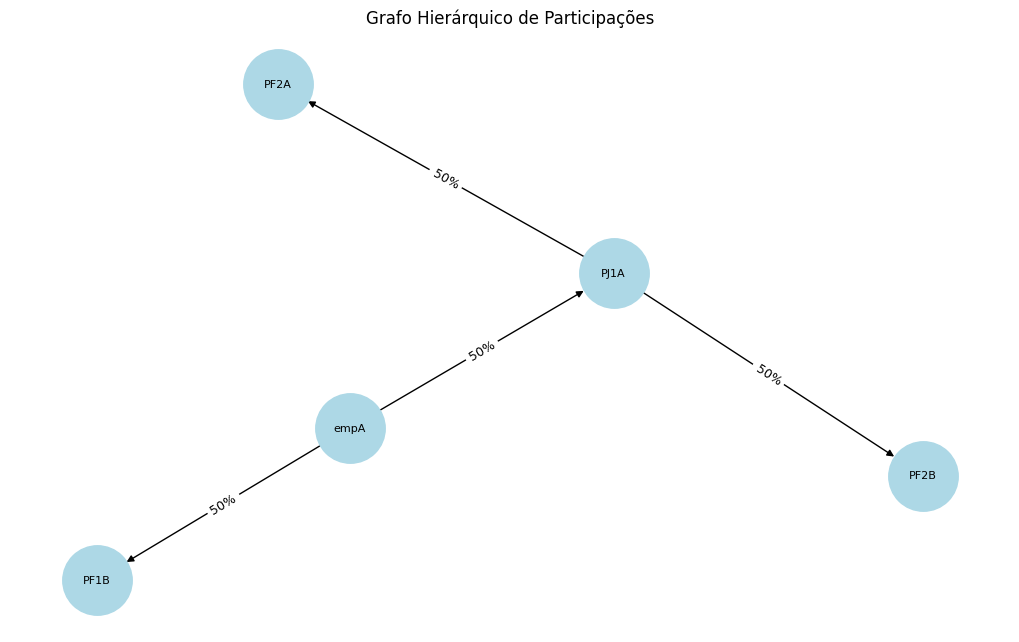

In [26]:
pos = nx.spring_layout(G)  # fallback caso Graphviz não esteja instalado


# 5) Desenhar o grafo
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=False, node_color='lightblue', node_size=2500, arrows=True)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

# 6) Adicionar os valores de participação nas arestas
edge_labels = nx.get_edge_attributes(G, 'pct')
edge_labels = {k: f'{v*100:.0f}%' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Grafo Hierárquico de Participações")
plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
def beneficiarios_finais(grafo, raiz, clientes):
    finais = {}

    def buscar(no, participacao):
        tipo = clientes.set_index("codigo_cliente").loc[no, "tipo_pessoa"]

        if tipo == "PF":
            finais[no] = finais.get(no, 0) + participacao
        else:
            for _, filho, dados in grafo.out_edges(no, data=True):
                buscar(filho, participacao * dados["pct"])

    buscar(raiz, 1.0)
    return {pf: round(p * 100, 2) for pf, p in finais.items()}


In [28]:



# 4) Testando para a empresa "empA"
bf_empA = beneficiarios_finais(G, "empA", df_clientes)
print("Beneficiários Finais de empA e suas participações:")
for pf, pct in bf_empA.items():
    doc = df_clientes.loc[df_clientes.codigo_cliente==pf, "documento"].iat[0]
    print(f"- {pf} ({doc}): {pct:.2f}%")

# Saída esperada:
# - PF1B (222.222.222-22): 50.00%
# - PF2A (333.333.333-33): 25.00%
# - PF2B (444.444.444-44): 25.00%


Beneficiários Finais de empA e suas participações:
- PF1B (222.222.222-22): 50.00%
- PF2A (333.333.333-33): 25.00%
- PF2B (444.444.444-44): 25.00%


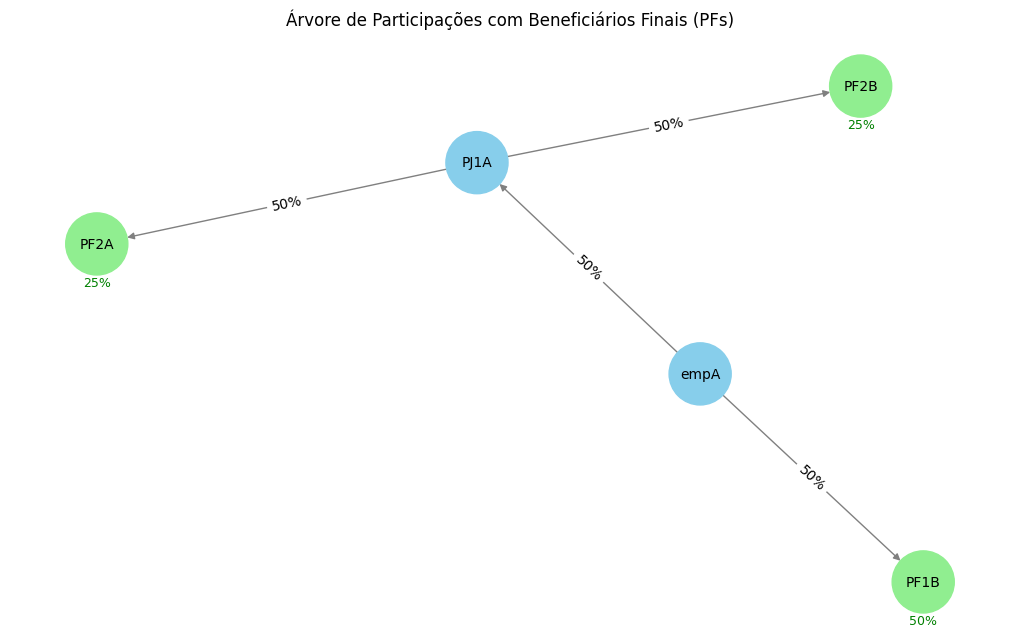

In [29]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1) DataFrames
df_particip = pd.DataFrame([
    ("empA", "PF1B", 0.5),
    ("empA", "PJ1A", 0.5),
    ("PJ1A", "PF2A", 0.5),
    ("PJ1A", "PF2B", 0.5),
], columns=["parent", "child", "pct"])

df_clientes = pd.DataFrame([
    ("empA", "PJ", "00.000.000/0001-01"),
    ("PJ1A", "PJ", "11.111.111/0001-11"),
    ("PF1B", "PF", "222.222.222-22"),
    ("PF2A", "PF", "333.333.333-33"),
    ("PF2B", "PF", "444.444.444-44"),
], columns=["codigo_cliente", "tipo_pessoa", "documento"])

# 2) Criar o grafo
G = nx.DiGraph()
for _, row in df_particip.iterrows():
    G.add_edge(row["parent"], row["child"], pct=row["pct"])

# 3) Calcular participações efetivas
def beneficiarios_finais(grafo, raiz, clientes):
    finais = {}
    def buscar(no, participacao):
        tipo = clientes.set_index("codigo_cliente").loc[no, "tipo_pessoa"]
        if tipo == "PF":
            finais[no] = finais.get(no, 0) + participacao
        else:
            for _, filho, dados in grafo.out_edges(no, data=True):
                buscar(filho, participacao * dados["pct"])
    buscar(raiz, 1.0)
    return {pf: round(p * 100, 2) for pf, p in finais.items()}

participacoes = beneficiarios_finais(G, "empA", df_clientes)

# 4) Desenhar grafo com as participações nas folhas
def desenhar_grafo(grafo, clientes, participacoes):
    pos = nx.spring_layout(grafo, seed=42)
    cores = []
    for no in grafo.nodes:
        tipo = clientes.set_index("codigo_cliente").loc[no, "tipo_pessoa"]
        if tipo == "PF":
            cores.append("lightgreen")
        else:
            cores.append("skyblue")

    plt.figure(figsize=(10, 6))
    nx.draw(
        grafo, pos,
        with_labels=True,
        node_color=cores,
        node_size=2000,
        font_size=10,
        edge_color="gray",
        arrows=True
    )

    # Rótulos nas arestas: percentual de participação direta
    edge_labels = {
        (u, v): f"{d['pct']*100:.0f}%" for u, v, d in grafo.edges(data=True)
    }
    nx.draw_networkx_edge_labels(grafo, pos, edge_labels=edge_labels, font_color="black")

    # Adicionar participação efetiva ao lado dos PFs
    for no, valor in participacoes.items():
        x, y = pos[no]
        plt.text(x, y - 0.1, f"{valor:.0f}%", fontsize=9, ha='center', color="green")

    plt.title("Árvore de Participações com Beneficiários Finais (PFs)")
    plt.axis("off")
    plt.show()

# 5) Executar
desenhar_grafo(G, df_clientes, participacoes)
